In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os
import sys

In [29]:
class lane_dectection():
    def __init__(self,input):
        self.input = input
        self.input = cv2.resize(self.input, (960,640))
        self.vertices = np.array([[[0,550],[450,350],[600,350],[960,550]]])
        
    def grayscale(self):
        return cv2.cvtColor(self.input, cv2.COLOR_BGR2GRAY)
    
    def canny(self, low_threshold, high_threshold):
        return cv2.Canny(self.input, low_threshold, high_threshold)
    
    def gaussian_blur(self, kernel_size):
        self.input = cv2.GaussianBlur(self.input, (kernel_size, kernel_size), 0)
        self.input = cv2.GaussianBlur(self.input, (kernel_size, kernel_size), 0)
        return cv2.GaussianBlur(self.input, (kernel_size, kernel_size), 0)
    
    def region_of_interest(self, vertices):
        mask = np.zeros_like(self.input)
        cv2.fillPoly(mask, self.vertices, 255)
        masked_image = cv2.bitwise_and(self.input, mask)
        return masked_image
    
    def draw_lines(self, lines, color=[255, 0, 0], thickness=3):
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(self.input, (x1, y1), (x2, y2), color, thickness)
                
    def hough_lines(self, rho, theta, threshold, min_line_len, max_line_gap):
        lines = cv2.HoughLinesP(self.input, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
        line_img = np.zeros((self.input.shape[0], self.input.shape[1], 3), dtype=np.uint8)
        self.draw_lines(lines)
        return line_img, lines

    def run(self):
        self.input = self.grayscale()
        self.input = self.gaussian_blur(5)
        self.input = self.canny(50, 150)
        self.input = self.region_of_interest(self.vertices)
        line_img, lines = self.hough_lines(1, np.pi/180, 50, 100, 160)
        self.draw_lines(lines)
        return self.input

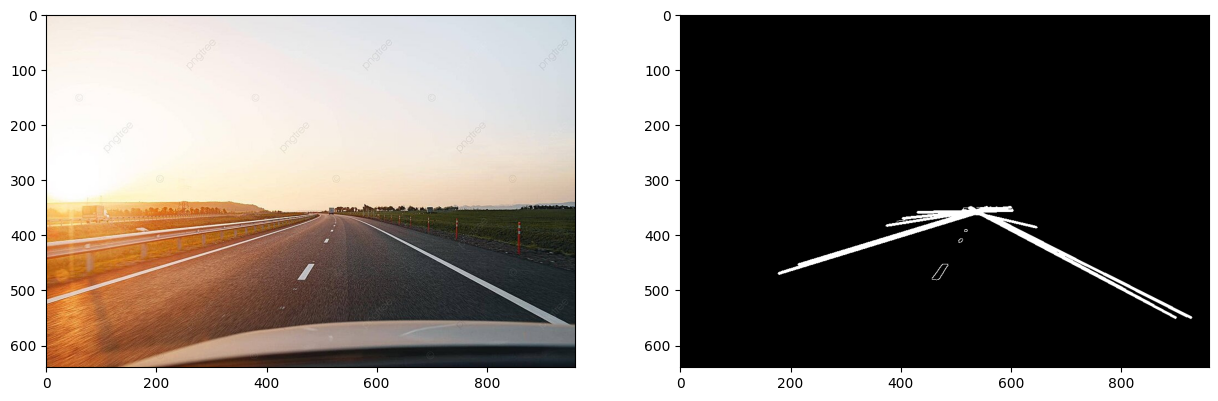

In [30]:
input = cv2.imread('road1.jpg')
model = lane_dectection(input)
output = model.run()
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(cv2.cvtColor(input, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(output, cmap='gray')